# Preprocesamiento y Modelado de Sentimiento

En este notebook realizamos el preprocesamiento final y el entrenamiento de un modelo de clasificación de sentimiento en reseñas de películas.

---

## Objetivos

- Cargar el dataset limpio preparado en el EDA.
- Dividir el conjunto en entrenamiento y prueba.
- Aplicar vectorización del texto con TF-IDF.
- Entrenar un primer modelo de machine learning.
- Evaluar el rendimiento inicial.

---


Cargamos librerias necesarias y los datos

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import pickle

df_reviews = pd.read_csv('../data/IMDB_reviews_clean.csv')

Dividimos en train/test: 

In [ ]:
X = df_reviews['review_clean']  # predictor
y = df_reviews['sentiment']     # target

# División 80% train, 20% test con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,        # Mantener proporción de clases
    random_state=42    # Para reproducibilidad
)

## Vectorización del texto con TF-IDF

Una vez que tenemos nuestros datos divididos en entrenamiento y prueba, transformamos el texto en vectores numéricos utilizando la técnica TF-IDF (Term Frequency – Inverse Document Frequency).

Esta técnica pondera las palabras según su frecuencia relativa dentro de un documento y su presencia en todo el corpus. De este modo:

- Se resalta el valor de las palabras representativas.
- Se penalizan palabras comunes (como “the”, “movie”, etc.) que aparecen en todos los documentos.

> Nota: La tokenización se realiza automáticamente dentro de `TfidfVectorizer`, por lo que no es necesario aplicar tokenización manualmente.

A continuación, ajustamos el vectorizador con el conjunto de entrenamiento (`fit_transform`) y lo aplicamos al conjunto de prueba (`transform`) para evitar fuga de datos (data leakage).


In [55]:
# Creamos el vectorizador con algunos parámetros básicos
vectorizer = TfidfVectorizer(
    max_df=0.95,             # Ignora palabras que aparecen en >95% de los documentos
    min_df=5,                # Ignora palabras que aparecen en <5 documentos
    max_features=10000       # Limita el vocabulario a las 5000 palabras más informativas
)

# Ajustamos y transformamos el conjunto de entrenamiento
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transformamos el conjunto de prueba (sin hacer fit)
X_test_tfidf = vectorizer.transform(X_test)

print("Vectorización completada.")
print(f"Matriz TF-IDF - Entrenamiento: {X_train_tfidf.shape}")
print(f"Matriz TF-IDF - Prueba: {X_test_tfidf.shape}")


Vectorización completada.
Matriz TF-IDF - Entrenamiento: (40000, 10000)
Matriz TF-IDF - Prueba: (10000, 10000)


## Modelado: Clasificación de Sentimiento

Ya podemos entrenar y evaluar distintos modelos de machine learning para clasificar las reseñas como positivas o negativas, utilizando como entrada la representación TF-IDF del texto.

### Modelos que vamos a comparar:

1. **Regresión Logística**  
   Un modelo lineal ampliamente utilizado como baseline en clasificación binaria. Rápido, interpretable y eficaz en textos vectorizados.

2. **Naive Bayes**  
   Modelo probabilístico basado en la independencia condicional entre características. Tradicionalmente muy fuerte en tareas de clasificación de texto.

3. **Máquinas de Vectores de Soporte (SVM)**  
   Modelo robusto que maximiza el margen entre clases. Requiere más tiempo de entrenamiento, pero suele ofrecer muy buen rendimiento con datos bien representados.

---

Evaluaremos los modelos utilizando las siguientes métricas:

- **Accuracy (precisión global)**  
- **Matriz de confusión**  
- **Classification report**: precisión, recall y F1-score

Comenzamos entrenando la regresión logística como primer modelo baseline.


In [56]:
# Entrenamos el modelo
modelo_log = LogisticRegression(random_state=42)
modelo_log.fit(X_train_tfidf, y_train)

# Predicciones
y_pred_log = modelo_log.predict(X_test_tfidf)

# Accuracy
accuracy_log = accuracy_score(y_test, y_pred_log)
print(f"Accuracy de Regresión Logística: {accuracy_log:.4f}")


Accuracy de Regresión Logística: 0.8930


In [57]:
# Informe completo de métricas
print("Classification Report:\n")
print(classification_report(y_test, y_pred_log))

Classification Report:

              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      5000
    positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



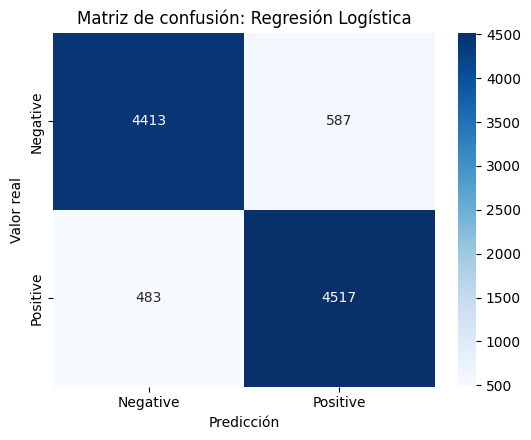

In [58]:
# Matriz de confusión
cm_log = confusion_matrix(y_test, y_pred_log)
labels = ['Negative', 'Positive']

plt.figure(figsize=(5.5, 4.5))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title('Matriz de confusión: Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.tight_layout()
plt.show()

La regresión logística nos ofrece una primera referencia del rendimiento del modelo sobre el conjunto de test.

Se aprecia una precisión general (accuracy) del 89% y la matriz de confusión muestra la ausencia de sesgos.




Veamos si un modelo Naive Bayes mejora el resultado:

In [59]:
# Entrenamos el modelo
modelo_nb = MultinomialNB()
modelo_nb.fit(X_train_tfidf, y_train)

# Predicciones
y_pred_nb = modelo_nb.predict(X_test_tfidf)

# Accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy de Naive Bayes: {accuracy_nb: .4f}")

Accuracy de Naive Bayes:  0.8563


In [60]:
# Informe completo de métricas
print("Classification Report:\n")
print(classification_report(y_test, y_pred_nb))

Classification Report:

              precision    recall  f1-score   support

    negative       0.86      0.85      0.86      5000
    positive       0.86      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



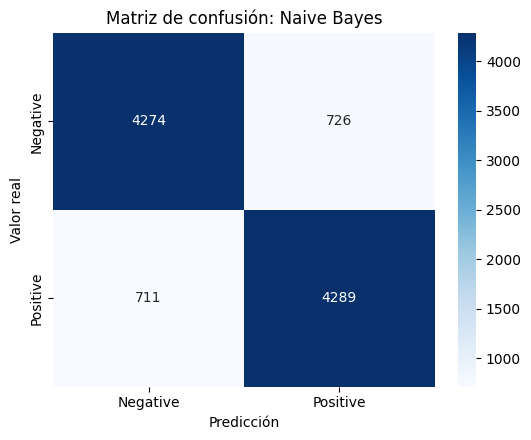

In [61]:
#Matriz de confusión
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(5.5, 4.5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)

plt.title('Matriz de confusión: Naive Bayes')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.tight_layout()
plt.show()


Por último implementamos SVM, en este caso usamos `LinearSVC`, una versión optimizada de SVM lineal para trabajar eficientemente con datos de alta dimensión y dispersos, como los que genera TF-IDF. Después compararemos los tres modelos:

In [62]:
# Entrenamos el modelo
modelo_svm = LinearSVC(random_state=42)
modelo_svm.fit(X_train_tfidf, y_train)

# Predicciones
y_pred_svm = modelo_svm.predict(X_test_tfidf)

# Accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy de SVM: {accuracy_svm: .4f}")

Accuracy de SVM:  0.8879


In [63]:
# Informe completo de métricas
print("Classification Report:\n")
print(classification_report(y_test, y_pred_svm))

Classification Report:

              precision    recall  f1-score   support

    negative       0.89      0.88      0.89      5000
    positive       0.88      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



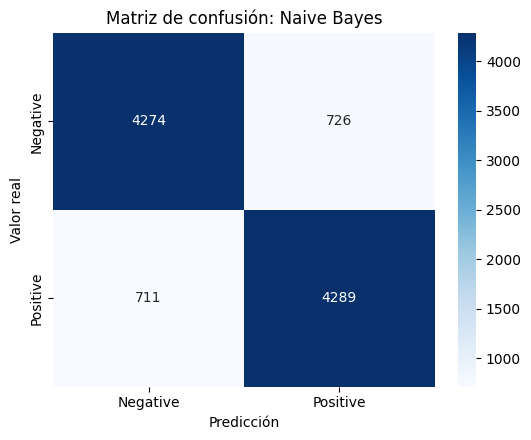

In [64]:
#Matriz de confusión
cm_svm = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(5.5, 4.5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)

plt.title('Matriz de confusión: Naive Bayes')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.tight_layout()
plt.show()

## Elección de modelo

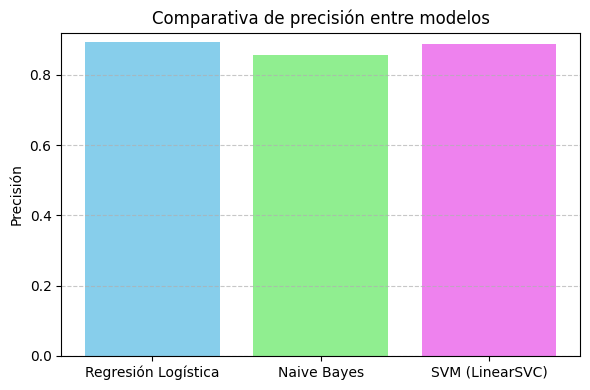

In [72]:
resultados = {
    'Regresión Logística': accuracy_log,
    'Naive Bayes': accuracy_nb,
    'SVM (LinearSVC)': accuracy_svm
}

plt.figure(figsize=(6, 4))
plt.bar(resultados.keys(), resultados.values(), color=['skyblue', 'lightgreen', 'violet'])
plt.title('Comparativa de precisión entre modelos')
plt.ylabel('Precisión')
plt.ylim(0, 0.92)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Tras evaluar los tres modelos entrenados (Regresión Logística, Naive Bayes y SVM), observamos que:

- **SVM (LinearSVC)** y **Regresión Logística** ofrecen un rendimiento prácticamente idéntico, alcanzando un F1-score y accuracy del 89%.
- **Naive Bayes** queda ligeramente por debajo, con un rendimiento del 86%.

Dado que `LinearSVC` es más robusto ante casos difíciles, generaliza bien en espacios de alta dimensión como los generados por TF-IDF, y es un modelo ampliamente utilizado en producción para tareas de NLP, lo seleccionamos como **modelo final** para desplegar.


## Guardamos el modelo final (y el vectorizador)

In [74]:
# Guardamos el modelo entrenado
with open('../model/modelo_svm.pkl', 'wb') as f:
    pickle.dump(modelo_svm, f)

# También guardamos el vectorizador
with open('../model/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("Modelo y vectorizador guardados correctamente.")

Modelo y vectorizador guardados correctamente.
